In [1]:
import os
import pandas as pd
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
from tqdm import tqdm

In [ ]:
# tpu 사용을 위한 준비
tpu_name = 'grpc://'+os.environ['COLAB_TPU_ADDR']

resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu=tpu_name)

tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)

strategy = tf.distribute.TPUStrategy(resolver)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_dir = './../../data/4d-block/'
train_df = pd.read_csv(os.path.join(data_dir,'train.csv'))
test_df = pd.read_csv(os.path.join(data_dir,'test.csv'))

In [ ]:
train_df.head()

,id,img_path,A,B,C,D,E,F,G,H,I,J
0,TRAIN_00000,./train/TRAIN_00000.jpg,1,0,0,0,0,0,0,0,0,0
1,TRAIN_00001,./train/TRAIN_00001.jpg,1,0,0,0,0,0,0,0,0,0
2,TRAIN_00002,./train/TRAIN_00002.jpg,1,0,0,0,0,0,0,0,0,0
3,TRAIN_00003,./train/TRAIN_00003.jpg,1,0,0,0,0,0,0,0,0,0
4,TRAIN_00004,./train/TRAIN_00004.jpg,1,0,0,0,0,0,0,0,0,0


In [ ]:
train_df.isnull().sum()

id          0
img_path    0
A           0
B           0
C           0
D           0
E           0
F           0
G           0
H           0
I           0
J           0
dtype: int64

In [ ]:
train, val = train_test_split(train_df, test_size=0.35, random_state=2023)

In [ ]:
train.reset_index(drop=True, inplace=True)
val.reset_index(drop=True, inplace=True)

In [ ]:
train.shape, val.shape

((21446, 12), (11548, 12))

In [ ]:
def _bytes_feature(value):
    if isinstance(value,type(tf.constant(0))):
        value = value.numpy()
    return tf.train.Feature(bytes_list = tf.train.BytesList(value = [value]))

def _float_feature(value):
    return tf.train.Feature(float_list = tf.train.FloatList(value = [value]))

def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

In [ ]:
train.head(3)

,id,img_path,A,B,C,D,E,F,G,H,I,J
0,TRAIN_15562,./train/TRAIN_15562.jpg,1,1,0,1,0,0,1,0,1,1
1,TRAIN_18654,./train/TRAIN_18654.jpg,0,0,1,1,1,1,1,1,0,0
2,TRAIN_17763,./train/TRAIN_17763.jpg,0,1,1,1,0,0,0,1,1,1


In [ ]:
img_size = 224
epochs = 10
batch_size =128

In [ ]:
writer_image = tf.io.TFRecordWriter(os.path.join(data_dir,'image_train.tfrecord'))

for i in tqdm(range(train.shape[0])):
    src = cv2.imread(os.path.join(data_dir,train.iloc[i,1]))
    dst = cv2.cvtColor(src, cv2.COLOR_BGR2RGB)
    dst = cv2.resize(dst,(img_size,img_size), interpolation = cv2.INTER_CUBIC)
    bimage = dst.tobytes()

    classes = np.array(train.loc[i,'A':'J'], dtype=np.uint8).tobytes()

    example = tf.train.Example(
        features = tf.train.Features(
            feature={
            'image':_bytes_feature(bimage),
            'class': _bytes_feature(classes)
            }
        )
    )

    writer_image.write(example.SerializeToString())

writer_image.close()

100%|███████████████████████████████████████████████████████████████████████████| 21446/21446 [01:18<00:00, 274.13it/s]


In [ ]:
writer_image = tf.io.TFRecordWriter(os.path.join(data_dir,'image_val.tfrecord'))

for i in tqdm(range(val.shape[0])):
    src = cv2.imread(os.path.join(data_dir,val.iloc[i,1]))
    dst = cv2.cvtColor(src, cv2.COLOR_BGR2RGB)
    dst = cv2.resize(dst,(img_size,img_size), interpolation = cv2.INTER_CUBIC)
    bimage = dst.tobytes()

    classes = np.array(val.loc[i,'A':'J'], dtype=np.uint8).tobytes()

    example = tf.train.Example(
        features = tf.train.Features(
            feature={
            'image':_bytes_feature(bimage),
            'class': _bytes_feature(classes)
            }
        )
    )

    writer_image.write(example.SerializeToString())

writer_image.close()

100%|███████████████████████████████████████████████████████████████████████████| 11548/11548 [00:42<00:00, 274.72it/s]


In [ ]:
writer_image = tf.io.TFRecordWriter(os.path.join(data_dir,'image_test.tfrecord'))

for i in tqdm(range(test_df.shape[0])):
    src = cv2.imread(os.path.join(data_dir,test_df.iloc[i,1]))
    dst = cv2.cvtColor(src, cv2.COLOR_BGR2RGB)
    dst = cv2.resize(dst,(img_size,img_size), interpolation = cv2.INTER_CUBIC)
    bimage = dst.tobytes()

    classes = np.array(test_df.loc[i,'A':'J'], dtype=np.uint8).tobytes()

    example = tf.train.Example(
        features = tf.train.Features(
            feature={
            'image':_bytes_feature(bimage),
            'class': _bytes_feature(classes)
            }
        )
    )

    writer_image.write(example.SerializeToString())

writer_image.close()

100%|█████████████████████████████████████████████████████████████████████████████| 1460/1460 [00:09<00:00, 147.62it/s]


In [ ]:
def _parse_function(tfrecord_serialized):
    features = {'image' : tf.io.FixedLenFeature([],tf.string),
                'classes' : tf.io.FixedLenFeature([],tf.string)
               }
    parsed_features = tf.io.parse_single_example(tfrecord_serialized, features)
    
    image = tf.io.decode_raw(parsed_features['image'], tf.uint8)
    image = tf.reshape(image, [img_size,img_size,3])
    
    classes = tf.io.decode_raw(parsed_features['classes'], tf.uint8)
    classes = tf.squeeze(classes)
    
    return image, classes

def _parse_function2(tfrecord_serialized):
    features = {'image' : tf.io.FixedLenFeature([],tf.string),
                'classes' : tf.io.FixedLenFeature([],tf.string)
               }
    parsed_features = tf.io.parse_single_example(tfrecord_serialized, features)
    
    image = tf.io.decode_raw(parsed_features['image'], tf.uint8)
    image = tf.reshape(image, [img_size,img_size,3])

    
    return image

In [ ]:
train_ds = tf.data.TFRecordDataset(os.path.join(data_dir,'image_train.tfrecord'))
val_ds = tf.data.TFRecordDataset(os.path.join(data_dir,'image_val.tfrecord'))
test_ds = tf.data.TFRecordDataset(os.path.join(data_dir,'image_test.tfrecord'))

train_ds = train_ds.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_ds = train_ds.shuffle(2000).prefetch(tf.data.experimental.AUTOTUNE).batch(batch_size)

val_ds = val_ds.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_ds = val_ds.shuffle(2000).prefetch(tf.data.experimental.AUTOTUNE).batch(batch_size)

test_ds = test_ds.map(_parse_function2, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_ds = test_ds.shuffle(2000).prefetch(tf.data.experimental.AUTOTUNE).batch(batch_size)

In [14]:
class AlexNet(tf.keras.Model):
    def __init__(self):
        super(AlexNet,self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(filters=48,kernel_size=11,strides = 4,input_shape=(224,224,3))
        self.conv2 = tf.keras.layers.Conv2D(filters=128,kernel_size=5,strides = 4)
        self.conv3 = tf.keras.layers.Conv2D(filters=192,kernel_size=3,strides = 4)
        self.conv4 = tf.keras.layers.Conv2D(filters=128,kernel_size=3,strides = 4)
        self.batchnormal = tf.keras.layers.BatchNormalization()
        self.pool = tf.keras.layers.MaxPool2D(pool_size=3, strides=2)
        self.relu = tf.keras.layers.ReLU()
        self.dense1 = tf.keras.layers.Dense(units = 4096)
        self.dense2 = tf.keras.layers.Dense(units = 1000)
        self.dropout = tf.keras.layers.Dropout(0.5)
        self.flatten = tf.keras.layers.Flatten()

    def call(self,input,training=False):
        # 첫번째 레이어 x
        x = self.conv1(input)
        x = self.batchnormal(x)
        x = self.relu(x)
        x = self.pool(x)

        # # 첫번째 레이어 y
        y = self.conv1(input)
        y = self.batchnormal(y)
        y = self.relu(y)
        y = self.pool(y)
        
        # 두번째 레이어 x
        x = self.conv2(x)
        x = self.batchnormal(x)
        x = self.relu(x)
        x = self.pool(x)
        
        # 두번째 레이어 y
        y = self.conv2(y)
        y = self.batchnormal(y)
        y = self.relu(y)
        y = self.pool(y)
  
        # 세번째 레이어 x
        x = self.conv3(x)
        x = self.batchnormal(x)
        x = self.relu(x)
        x = self.pool(x)
        
        # 세번째 레이어 y
        y = self.conv3(y)
        y = self.batchnormal(y)
        y = self.relu(y)
        y = self.pool(y)
        
        
        # 네번째 레이어 x
        x = self.conv3(x)
        x = self.batchnormal(x)
        x = self.relu(x)
        x = self.pool(x)
        
        # 네번째 레이어 y
        y = self.conv3(y)
        y = self.batchnormal(y)
        y = self.relu(y)
        y = self.pool(y)
                
        
        # 다섯번째 레이어 x
        x = self.conv4(x)
        x = self.batchnormal(x)
        x = self.relu(x)
        x = self.pool(x)
        
        # 다섯번째 레이어 y
        y = self.conv4(y)
        y = self.batchnormal(y)
        y = self.relu(y)
        y = self.pool(y)
        
                
        # 여섯번째 레이어에 들어갈 데이터 준비 
        z = tf.keras.layers.concatenate([x,y], axis=-1)
        z = self.flatten(z)
        
        # 여섯번째 레이어 
        z = self.dense1(z)
        z = self.relu(z)

        # 일곱번째 레이어 - 논문에서는 여기에서 dropout를 넣어줬다고 적혀있다.
        z = self.dense1(z)
        z = self.relu(z)
        z = self.dropout(z)
        
        # 마지막 레이어
        z = self.dense2(z)

        return z

TypeError: ignored

In [64]:
class AlexNet(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.conv1 = tf.keras.layers.Conv2D(filters=48,kernel_size=11,strides = 4)
        self.conv2 = tf.keras.layers.Conv2D(filters=128,kernel_size=5,strides = 4)
        self.conv3 = tf.keras.layers.Conv2D(filters=192,kernel_size=3,strides = 4)
        self.conv4 = tf.keras.layers.Conv2D(filters=128,kernel_size=3,strides = 4)
        self.batchnormal1 = tf.keras.layers.BatchNormalization()
        self.batchnormal2 = tf.keras.layers.BatchNormalization()
        self.pool = tf.keras.layers.MaxPool2D(pool_size=3, strides=2)
        self.relu = tf.keras.layers.ReLU()
        self.dense1 = tf.keras.layers.Dense(units = 4096)
        self.dense2 = tf.keras.layers.Dense(units = 1000)
        self.dropout = tf.keras.layers.Dropout(0.5)
        self.flatten = tf.keras.layers.Flatten()

    def call(self,input,training=False):
        # 첫번째 레이어 x
        x = self.conv1(input)
        x = self.batchnormal1(x)
        x = self.relu(x)
        x = self.pool(x)

        # 두번째 레이어 x
        x = self.conv2(x)
        x = self.batchnormal2(x)
        x = self.relu(x)
        x = self.pool(x)

        # 두번째 레이어 y
        y = self.conv2(y)
        y = self.batchnormal(y)
        y = self.relu(y)
        y = self.pool(y)
  
        # 세번째 레이어 x
        x = self.conv3(x)
        x = self.batchnormal(x)
        x = self.relu(x)
        x = self.pool(x)
        
        # 세번째 레이어 y
        y = self.conv3(y)
        y = self.batchnormal(y)
        y = self.relu(y)
        y = self.pool(y)
        
        
        # 네번째 레이어 x
        x = self.conv3(x)
        x = self.batchnormal(x)
        x = self.relu(x)
        x = self.pool(x)
        
        # 네번째 레이어 y
        y = self.conv3(y)
        y = self.batchnormal(y)
        y = self.relu(y)
        y = self.pool(y)
                
        
        # 다섯번째 레이어 x
        x = self.conv4(x)
        x = self.batchnormal(x)
        x = self.relu(x)
        x = self.pool(x)
        
        # 다섯번째 레이어 y
        y = self.conv4(y)
        y = self.batchnormal(y)
        y = self.relu(y)
        y = self.pool(y)
        
                
        # 여섯번째 레이어에 들어갈 데이터 준비 
        z = tf.keras.layers.concatenate([x,y], axis=-1)
        z = self.flatten(z)
        return z



In [65]:
alexnet = AlexNet()

In [66]:
input_shape = (4, 28, 28, 3)
input_shape[1:]


(28, 28, 3)

In [70]:
# 
alexnet.build(input_shape=(25,224,224,3))

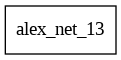

In [71]:
tf.keras.utils.plot_model(alexnet, show_shapes=True, show_dtype=True)

In [72]:

alexnet.summary()

Model: "alex_net_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_43 (Conv2D)          multiple                  17472     
                                                                 
 conv2d_44 (Conv2D)          multiple                  153728    
                                                                 
 conv2d_45 (Conv2D)          multiple                  0 (unused)
                                                                 
 conv2d_46 (Conv2D)          multiple                  0 (unused)
                                                                 
 batch_normalization_14 (Bat  multiple                 192       
 chNormalization)                                                
                                                                 
 batch_normalization_15 (Bat  multiple                 512       
 chNormalization)                                      